In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'scale',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_scale_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 828)
(631390, 1)
validation
(74368, 828)
(74368, 1)
test
(85358, 828)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:18 - loss: 0.0615 - STD: 9.8776e-05 - MAE: 0.2392

 4/64 [>.............................] - ETA: 1s - loss: 0.0300 - STD: 1.9160e-04 - MAE: 0.1310  

 5/64 [=>............................] - ETA: 2s - loss: 0.0298 - STD: 1.8338e-04 - MAE: 0.1305

 6/64 [=>............................] - ETA: 2s - loss: 0.0297 - STD: 1.7541e-04 - MAE: 0.1300

 7/64 [==>...........................] - ETA: 6s - loss: 0.0296 - STD: 1.7022e-04 - MAE: 0.1280

11/64 [====>.........................] - ETA: 4s - loss: 0.0248 - STD: 1.8003e-04 - MAE: 0.1098

12/64 [====>.........................] - ETA: 3s - loss: 0.0238 - STD: 1.8569e-04 - MAE: 0.1072

13/64 [=====>........................] - ETA: 3s - loss: 0.0230 - STD: 1.9116e-04 - MAE: 0.1064

14/64 [=====>........................] - ETA: 3s - loss: 0.0225 - STD: 1.9636e-04 - MAE: 0.1066

15/64 [======>.......................] - ETA: 3s - loss: 0.0221 - STD: 2.0150e-04 - MAE: 0.1072

16/64 [======>.......................] - ETA: 3s - loss: 0.0217 - STD: 2.0666e-04 - MAE: 0.1076

17/64 [======>.......................] - ETA: 3s - loss: 0.0214 - STD: 2.1184e-04 - MAE: 0.1074

18/64 [=======>......................] - ETA: 3s - loss: 0.0209 - STD: 2.1714e-04 - MAE: 0.1066

19/64 [=======>......................] - ETA: 3s - loss: 0.0205 - STD: 2.2250e-04 - MAE: 0.1053

20/64 [========>.....................] - ETA: 3s - loss: 0.0201 - STD: 2.2751e-04 - MAE: 0.1036

21/64 [========>.....................] - ETA: 2s - loss: 0.0197 - STD: 2.3218e-04 - MAE: 0.1016

22/64 [=========>....................] - ETA: 2s - loss: 0.0194 - STD: 2.3643e-04 - MAE: 0.0996

23/64 [=========>....................] - ETA: 2s - loss: 0.0191 - STD: 2.4085e-04 - MAE: 0.0979

24/64 [==========>...................] - ETA: 2s - loss: 0.0189 - STD: 2.4524e-04 - MAE: 0.0964

25/64 [==========>...................] - ETA: 2s - loss: 0.0188 - STD: 2.4957e-04 - MAE: 0.0949

26/64 [===========>..................] - ETA: 2s - loss: 0.0185 - STD: 2.5407e-04 - MAE: 0.0936

27/64 [===========>..................] - ETA: 2s - loss: 0.0184 - STD: 2.5901e-04 - MAE: 0.0923

28/64 [============>.................] - ETA: 2s - loss: 0.0182 - STD: 2.6439e-04 - MAE: 0.0912

29/64 [============>.................] - ETA: 2s - loss: 0.0180 - STD: 2.7019e-04 - MAE: 0.0903

30/64 [=============>................] - ETA: 2s - loss: 0.0178 - STD: 2.7637e-04 - MAE: 0.0895

31/64 [=============>................] - ETA: 2s - loss: 0.0177 - STD: 2.8270e-04 - MAE: 0.0890

32/64 [==============>...............] - ETA: 2s - loss: 0.0175 - STD: 2.8947e-04 - MAE: 0.0886

33/64 [==============>...............] - ETA: 2s - loss: 0.0174 - STD: 2.9663e-04 - MAE: 0.0884

34/64 [==============>...............] - ETA: 1s - loss: 0.0172 - STD: 3.0395e-04 - MAE: 0.0883

35/64 [===============>..............] - ETA: 1s - loss: 0.0171 - STD: 3.1130e-04 - MAE: 0.0882

36/64 [===============>..............] - ETA: 1s - loss: 0.0170 - STD: 3.1895e-04 - MAE: 0.0880

37/64 [================>.............] - ETA: 1s - loss: 0.0169 - STD: 3.2658e-04 - MAE: 0.0878

38/64 [================>.............] - ETA: 1s - loss: 0.0168 - STD: 3.3422e-04 - MAE: 0.0875

39/64 [=================>............] - ETA: 1s - loss: 0.0167 - STD: 3.4199e-04 - MAE: 0.0871

40/64 [=================>............] - ETA: 1s - loss: 0.0166 - STD: 3.4960e-04 - MAE: 0.0867

41/64 [==================>...........] - ETA: 1s - loss: 0.0165 - STD: 3.5761e-04 - MAE: 0.0862

42/64 [==================>...........] - ETA: 1s - loss: 0.0164 - STD: 3.6555e-04 - MAE: 0.0856

43/64 [===================>..........] - ETA: 1s - loss: 0.0163 - STD: 3.7366e-04 - MAE: 0.0851

44/64 [===================>..........] - ETA: 1s - loss: 0.0162 - STD: 3.8229e-04 - MAE: 0.0847

45/64 [====================>.........] - ETA: 1s - loss: 0.0161 - STD: 3.9115e-04 - MAE: 0.0842

46/64 [====================>.........] - ETA: 1s - loss: 0.0161 - STD: 4.0043e-04 - MAE: 0.0838

47/64 [=====================>........] - ETA: 1s - loss: 0.0160 - STD: 4.1018e-04 - MAE: 0.0833

48/64 [=====================>........] - ETA: 1s - loss: 0.0159 - STD: 4.2016e-04 - MAE: 0.0829

49/64 [=====================>........] - ETA: 0s - loss: 0.0158 - STD: 4.3092e-04 - MAE: 0.0827

50/64 [======================>.......] - ETA: 0s - loss: 0.0157 - STD: 4.4190e-04 - MAE: 0.0824

51/64 [======================>.......] - ETA: 0s - loss: 0.0157 - STD: 4.5392e-04 - MAE: 0.0822

52/64 [=======================>......] - ETA: 0s - loss: 0.0156 - STD: 4.6640e-04 - MAE: 0.0821

53/64 [=======================>......] - ETA: 0s - loss: 0.0156 - STD: 4.7914e-04 - MAE: 0.0819

54/64 [========================>.....] - ETA: 0s - loss: 0.0155 - STD: 4.9255e-04 - MAE: 0.0818

55/64 [========================>.....] - ETA: 0s - loss: 0.0154 - STD: 5.0665e-04 - MAE: 0.0816

56/64 [=========================>....] - ETA: 0s - loss: 0.0154 - STD: 5.2111e-04 - MAE: 0.0815

57/64 [=========================>....] - ETA: 0s - loss: 0.0153 - STD: 5.3634e-04 - MAE: 0.0813

58/64 [==========================>...] - ETA: 0s - loss: 0.0153 - STD: 5.5216e-04 - MAE: 0.0811

59/64 [==========================>...] - ETA: 0s - loss: 0.0153 - STD: 5.6865e-04 - MAE: 0.0809

60/64 [===========================>..] - ETA: 0s - loss: 0.0152 - STD: 5.8581e-04 - MAE: 0.0807

61/64 [===========================>..] - ETA: 0s - loss: 0.0152 - STD: 6.0381e-04 - MAE: 0.0804

62/64 [============================>.] - ETA: 0s - loss: 0.0151 - STD: 6.2268e-04 - MAE: 0.0802

63/64 [============================>.] - ETA: 0s - loss: 0.0151 - STD: 6.4247e-04 - MAE: 0.0800

64/64 [==============================] - ETA: 0s - loss: 0.0150 - STD: 6.6382e-04 - MAE: 0.0798

64/64 [==============================] - 6s 73ms/step - loss: 0.0150 - STD: 6.6382e-04 - MAE: 0.0798 - val_loss: 0.0164 - val_STD: 0.0015 - val_MAE: 0.0775


Epoch 2/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0116 - STD: 0.0021 - MAE: 0.0665

 2/64 [..............................] - ETA: 3s - loss: 0.0120 - STD: 0.0022 - MAE: 0.0677

 3/64 [>.............................] - ETA: 3s - loss: 0.0123 - STD: 0.0023 - MAE: 0.0688

 4/64 [>.............................] - ETA: 3s - loss: 0.0124 - STD: 0.0023 - MAE: 0.0694

 5/64 [=>............................] - ETA: 3s - loss: 0.0123 - STD: 0.0024 - MAE: 0.0696

 6/64 [=>............................] - ETA: 3s - loss: 0.0124 - STD: 0.0025 - MAE: 0.0700

 7/64 [==>...........................] - ETA: 3s - loss: 0.0124 - STD: 0.0026 - MAE: 0.0701

 8/64 [==>...........................] - ETA: 3s - loss: 0.0124 - STD: 0.0027 - MAE: 0.0702

 9/64 [===>..........................] - ETA: 3s - loss: 0.0123 - STD: 0.0028 - MAE: 0.0701

10/64 [===>..........................] - ETA: 3s - loss: 0.0123 - STD: 0.0029 - MAE: 0.0700

11/64 [====>.........................] - ETA: 3s - loss: 0.0123 - STD: 0.0030 - MAE: 0.0699

12/64 [====>.........................] - ETA: 3s - loss: 0.0123 - STD: 0.0031 - MAE: 0.0697

13/64 [=====>........................] - ETA: 3s - loss: 0.0123 - STD: 0.0032 - MAE: 0.0696

14/64 [=====>........................] - ETA: 3s - loss: 0.0123 - STD: 0.0033 - MAE: 0.0693

15/64 [======>.......................] - ETA: 3s - loss: 0.0122 - STD: 0.0035 - MAE: 0.0691

16/64 [======>.......................] - ETA: 3s - loss: 0.0122 - STD: 0.0036 - MAE: 0.0689

17/64 [======>.......................] - ETA: 3s - loss: 0.0121 - STD: 0.0038 - MAE: 0.0688

18/64 [=======>......................] - ETA: 2s - loss: 0.0121 - STD: 0.0039 - MAE: 0.0687

19/64 [=======>......................] - ETA: 2s - loss: 0.0121 - STD: 0.0041 - MAE: 0.0686

20/64 [========>.....................] - ETA: 2s - loss: 0.0120 - STD: 0.0043 - MAE: 0.0685

21/64 [========>.....................] - ETA: 2s - loss: 0.0120 - STD: 0.0045 - MAE: 0.0684

22/64 [=========>....................] - ETA: 2s - loss: 0.0120 - STD: 0.0048 - MAE: 0.0683

23/64 [=========>....................] - ETA: 2s - loss: 0.0119 - STD: 0.0050 - MAE: 0.0681

24/64 [==========>...................] - ETA: 2s - loss: 0.0119 - STD: 0.0053 - MAE: 0.0680

25/64 [==========>...................] - ETA: 2s - loss: 0.0118 - STD: 0.0056 - MAE: 0.0678

26/64 [===========>..................] - ETA: 2s - loss: 0.0118 - STD: 0.0059 - MAE: 0.0677

27/64 [===========>..................] - ETA: 2s - loss: 0.0118 - STD: 0.0062 - MAE: 0.0675

28/64 [============>.................] - ETA: 2s - loss: 0.0117 - STD: 0.0066 - MAE: 0.0674

29/64 [============>.................] - ETA: 2s - loss: 0.0117 - STD: 0.0070 - MAE: 0.0672

30/64 [=============>................] - ETA: 2s - loss: 0.0117 - STD: 0.0074 - MAE: 0.0671

31/64 [=============>................] - ETA: 2s - loss: 0.0116 - STD: 0.0079 - MAE: 0.0669

32/64 [==============>...............] - ETA: 2s - loss: 0.0116 - STD: 0.0084 - MAE: 0.0667

33/64 [==============>...............] - ETA: 1s - loss: 0.0115 - STD: 0.0089 - MAE: 0.0666

34/64 [==============>...............] - ETA: 1s - loss: 0.0114 - STD: 0.0095 - MAE: 0.0664

35/64 [===============>..............] - ETA: 1s - loss: 0.0114 - STD: 0.0101 - MAE: 0.0661

36/64 [===============>..............] - ETA: 1s - loss: 0.0113 - STD: 0.0108 - MAE: 0.0658

37/64 [================>.............] - ETA: 1s - loss: 0.0112 - STD: 0.0114 - MAE: 0.0655

38/64 [================>.............] - ETA: 1s - loss: 0.0111 - STD: 0.0122 - MAE: 0.0652

39/64 [=================>............] - ETA: 1s - loss: 0.0110 - STD: 0.0130 - MAE: 0.0649

40/64 [=================>............] - ETA: 1s - loss: 0.0110 - STD: 0.0138 - MAE: 0.0646

41/64 [==================>...........] - ETA: 1s - loss: 0.0109 - STD: 0.0147 - MAE: 0.0643

42/64 [==================>...........] - ETA: 1s - loss: 0.0108 - STD: 0.0156 - MAE: 0.0640

43/64 [===================>..........] - ETA: 1s - loss: 0.0107 - STD: 0.0166 - MAE: 0.0637

44/64 [===================>..........] - ETA: 1s - loss: 0.0106 - STD: 0.0175 - MAE: 0.0634

45/64 [====================>.........] - ETA: 1s - loss: 0.0105 - STD: 0.0185 - MAE: 0.0630

46/64 [====================>.........] - ETA: 1s - loss: 0.0104 - STD: 0.0195 - MAE: 0.0627

47/64 [=====================>........] - ETA: 1s - loss: 0.0103 - STD: 0.0205 - MAE: 0.0624

48/64 [=====================>........] - ETA: 1s - loss: 0.0102 - STD: 0.0215 - MAE: 0.0621

49/64 [=====================>........] - ETA: 0s - loss: 0.0101 - STD: 0.0226 - MAE: 0.0617

50/64 [======================>.......] - ETA: 0s - loss: 0.0100 - STD: 0.0236 - MAE: 0.0614

51/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 0.0245 - MAE: 0.0610

52/64 [=======================>......] - ETA: 0s - loss: 0.0098 - STD: 0.0255 - MAE: 0.0607

54/64 [========================>.....] - ETA: 0s - loss: 0.0097 - STD: 0.0276 - MAE: 0.0601

55/64 [========================>.....] - ETA: 0s - loss: 0.0096 - STD: 0.0286 - MAE: 0.0597

56/64 [=========================>....] - ETA: 0s - loss: 0.0095 - STD: 0.0295 - MAE: 0.0594

57/64 [=========================>....] - ETA: 0s - loss: 0.0094 - STD: 0.0305 - MAE: 0.0591

58/64 [==========================>...] - ETA: 0s - loss: 0.0093 - STD: 0.0314 - MAE: 0.0588

59/64 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 0.0323 - MAE: 0.0585

60/64 [===========================>..] - ETA: 0s - loss: 0.0091 - STD: 0.0332 - MAE: 0.0582

61/64 [===========================>..] - ETA: 0s - loss: 0.0090 - STD: 0.0342 - MAE: 0.0579

62/64 [============================>.] - ETA: 0s - loss: 0.0090 - STD: 0.0351 - MAE: 0.0576

63/64 [============================>.] - ETA: 0s - loss: 0.0089 - STD: 0.0359 - MAE: 0.0573

64/64 [==============================] - ETA: 0s - loss: 0.0088 - STD: 0.0367 - MAE: 0.0571

64/64 [==============================] - 4s 65ms/step - loss: 0.0088 - STD: 0.0367 - MAE: 0.0571 - val_loss: 0.0054 - val_STD: 0.0662 - val_MAE: 0.0449


Epoch 3/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0038 - STD: 0.0897 - MAE: 0.0386

 2/64 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0925 - MAE: 0.0389

 3/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0930 - MAE: 0.0390

 4/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0933 - MAE: 0.0391

 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0933 - MAE: 0.0390

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0931 - MAE: 0.0387

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0933 - MAE: 0.0385

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0934 - MAE: 0.0384

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0935 - MAE: 0.0384

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0935 - MAE: 0.0382

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0937 - MAE: 0.0381

12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0939 - MAE: 0.0381

13/64 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0941 - MAE: 0.0379

14/64 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0943 - MAE: 0.0379

15/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0941 - MAE: 0.0378

16/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0941 - MAE: 0.0377

17/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0942 - MAE: 0.0376

18/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0946 - MAE: 0.0375

19/64 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0947 - MAE: 0.0375

20/64 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0947 - MAE: 0.0374

21/64 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0946 - MAE: 0.0373

22/64 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0947 - MAE: 0.0372

23/64 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0950 - MAE: 0.0371

24/64 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0953 - MAE: 0.0371

25/64 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0955 - MAE: 0.0370

26/64 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0954 - MAE: 0.0369

27/64 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0954 - MAE: 0.0369

28/64 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0956 - MAE: 0.0368

29/64 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0958 - MAE: 0.0367

30/64 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0959 - MAE: 0.0367

31/64 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0959 - MAE: 0.0366

32/64 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0960 - MAE: 0.0366

33/64 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0961 - MAE: 0.0365

34/64 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0963 - MAE: 0.0364

35/64 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0964 - MAE: 0.0364

36/64 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0965 - MAE: 0.0363

37/64 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0965 - MAE: 0.0363

38/64 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0966 - MAE: 0.0362

39/64 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0967 - MAE: 0.0361

40/64 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0968 - MAE: 0.0361

41/64 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0968 - MAE: 0.0360

42/64 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0968 - MAE: 0.0359

43/64 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0969 - MAE: 0.0359

44/64 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0969 - MAE: 0.0358

46/64 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0969 - MAE: 0.0357

47/64 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0970 - MAE: 0.0356

48/64 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0970 - MAE: 0.0356

49/64 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0972 - MAE: 0.0356

50/64 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0972 - MAE: 0.0355

51/64 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0972 - MAE: 0.0354

52/64 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0972 - MAE: 0.0354

53/64 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0973 - MAE: 0.0354

54/64 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0975 - MAE: 0.0353

55/64 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0975 - MAE: 0.0353

56/64 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0975 - MAE: 0.0352

57/64 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0976 - MAE: 0.0352

58/64 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0976 - MAE: 0.0351

59/64 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0977 - MAE: 0.0351

60/64 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0977 - MAE: 0.0350

61/64 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0977 - MAE: 0.0350

62/64 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0978 - MAE: 0.0349

63/64 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0978 - MAE: 0.0349

64/64 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0979 - MAE: 0.0349

64/64 [==============================] - 4s 65ms/step - loss: 0.0029 - STD: 0.0979 - MAE: 0.0349 - val_loss: 0.0027 - val_STD: 0.0833 - val_MAE: 0.0342


Epoch 4/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0023 - STD: 0.1017 - MAE: 0.0323

 2/64 [..............................] - ETA: 5s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0320

 3/64 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.1009 - MAE: 0.0319

 4/64 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.1009 - MAE: 0.0320

 5/64 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.1013 - MAE: 0.0320

 6/64 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.1012 - MAE: 0.0320

 7/64 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.1009 - MAE: 0.0319

 8/64 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.1007 - MAE: 0.0319

 9/64 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.1011 - MAE: 0.0319

10/64 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.1013 - MAE: 0.0319

11/64 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.1010 - MAE: 0.0319

12/64 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.1012 - MAE: 0.0319

13/64 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.1016 - MAE: 0.0319

14/64 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.1014 - MAE: 0.0319

15/64 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.1013 - MAE: 0.0319

16/64 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.1014 - MAE: 0.0319

17/64 [======>.......................] - ETA: 2s - loss: 0.0022 - STD: 0.1016 - MAE: 0.0319

18/64 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.1017 - MAE: 0.0318

19/64 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.1017 - MAE: 0.0318

20/64 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.1017 - MAE: 0.0318

21/64 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.1017 - MAE: 0.0318

22/64 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.1018 - MAE: 0.0318

23/64 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.1018 - MAE: 0.0318

24/64 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.1017 - MAE: 0.0318

25/64 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.1015 - MAE: 0.0317

26/64 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.1016 - MAE: 0.0317

28/64 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1018 - MAE: 0.0317

29/64 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1017 - MAE: 0.0317

30/64 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.1018 - MAE: 0.0317

31/64 [=============>................] - ETA: 1s - loss: 0.0022 - STD: 0.1018 - MAE: 0.0317

32/64 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.1017 - MAE: 0.0317

33/64 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.1017 - MAE: 0.0316

34/64 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.1018 - MAE: 0.0316

35/64 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.1018 - MAE: 0.0316

36/64 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.1018 - MAE: 0.0316

37/64 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.1020 - MAE: 0.0316

38/64 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.1019 - MAE: 0.0316

39/64 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.1020 - MAE: 0.0315

40/64 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.1019 - MAE: 0.0315

41/64 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1019 - MAE: 0.0315

42/64 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1019 - MAE: 0.0315

43/64 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1018 - MAE: 0.0315

44/64 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1019 - MAE: 0.0315

45/64 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1019 - MAE: 0.0315

46/64 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1019 - MAE: 0.0315

47/64 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1020 - MAE: 0.0314

48/64 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1020 - MAE: 0.0314

49/64 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1020 - MAE: 0.0314

50/64 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1020 - MAE: 0.0314

51/64 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1020 - MAE: 0.0314

52/64 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1020 - MAE: 0.0314

53/64 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1021 - MAE: 0.0314

54/64 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1021 - MAE: 0.0314

55/64 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1020 - MAE: 0.0314

56/64 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1020 - MAE: 0.0313

57/64 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1020 - MAE: 0.0313

58/64 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1020 - MAE: 0.0313

59/64 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1020 - MAE: 0.0313

60/64 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1021 - MAE: 0.0313

61/64 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1021 - MAE: 0.0313

62/64 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1021 - MAE: 0.0313

63/64 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1022 - MAE: 0.0313

64/64 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1022 - MAE: 0.0312

64/64 [==============================] - 4s 64ms/step - loss: 0.0021 - STD: 0.1022 - MAE: 0.0312 - val_loss: 0.0025 - val_STD: 0.0877 - val_MAE: 0.0332


Epoch 5/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0306

 2/64 [..............................] - ETA: 3s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0304

 3/64 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1022 - MAE: 0.0305

 4/64 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1026 - MAE: 0.0306

 5/64 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1014 - MAE: 0.0306

 6/64 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.1022 - MAE: 0.0307

 7/64 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.1026 - MAE: 0.0307

 8/64 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1026 - MAE: 0.0307

 9/64 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1023 - MAE: 0.0307

10/64 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1024 - MAE: 0.0306

11/64 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1027 - MAE: 0.0307

12/64 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1023 - MAE: 0.0306

13/64 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.1027 - MAE: 0.0306

14/64 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.1028 - MAE: 0.0307

15/64 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1027 - MAE: 0.0307

16/64 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1026 - MAE: 0.0306

17/64 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0306

18/64 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0306

19/64 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0306

20/64 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0306

21/64 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0306

22/64 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0306

23/64 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0306

24/64 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0306

25/64 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0306

26/64 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1027 - MAE: 0.0306

27/64 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1027 - MAE: 0.0305

28/64 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0305

29/64 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0305

30/64 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0305

31/64 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0305

32/64 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0305

33/64 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0305

34/64 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0305

35/64 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0305

36/64 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0304

37/64 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0304

38/64 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0304

39/64 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0304

40/64 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0304

41/64 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0304

42/64 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0304

43/64 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0304

44/64 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0303

45/64 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0303

46/64 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0303

47/64 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0303

48/64 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0303

49/64 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0303

50/64 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0303

51/64 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0303

52/64 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0303

53/64 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0303

54/64 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0302

55/64 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0302

56/64 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0302

57/64 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0302

58/64 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0302

60/64 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0302

61/64 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0302

62/64 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0302

63/64 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0302

64/64 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0302

64/64 [==============================] - 4s 65ms/step - loss: 0.0020 - STD: 0.1031 - MAE: 0.0302 - val_loss: 0.0024 - val_STD: 0.0880 - val_MAE: 0.0324


Epoch 6/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0021 - STD: 0.1026 - MAE: 0.0303

 2/64 [..............................] - ETA: 3s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0301

 3/64 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0298

 4/64 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1023 - MAE: 0.0297

 5/64 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1025 - MAE: 0.0296

 6/64 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1030 - MAE: 0.0296

 7/64 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1025 - MAE: 0.0296

 8/64 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1026 - MAE: 0.0296

 9/64 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0296

10/64 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0295

11/64 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1029 - MAE: 0.0295

12/64 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0296

13/64 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0296

14/64 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0296

15/64 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0296

16/64 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0296

17/64 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0296

18/64 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0296

19/64 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0296

20/64 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0296

21/64 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0296

22/64 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0296

23/64 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0296

24/64 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0296

25/64 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1030 - MAE: 0.0296

26/64 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0296

27/64 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1030 - MAE: 0.0295

28/64 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0295

29/64 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0295

30/64 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0295

31/64 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0295

32/64 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0295

33/64 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0295

34/64 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0295

35/64 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0295

36/64 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0295

37/64 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0295

38/64 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0295

39/64 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0295

40/64 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0295

41/64 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0295

42/64 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0295

43/64 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0295

44/64 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0295

45/64 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0295

46/64 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0295

47/64 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0295

48/64 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0294

49/64 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0294

50/64 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0294

51/64 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0294

52/64 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0294

53/64 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0294

55/64 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0294

56/64 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0294

57/64 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0294

58/64 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0294

59/64 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0294

60/64 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0293

61/64 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0293

62/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0293

63/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0293

64/64 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0293

64/64 [==============================] - 4s 65ms/step - loss: 0.0019 - STD: 0.1035 - MAE: 0.0293 - val_loss: 0.0024 - val_STD: 0.0919 - val_MAE: 0.0316


Epoch 7/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0288

 2/64 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0290

 3/64 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0289

 4/64 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1036 - MAE: 0.0289

 5/64 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0288

 6/64 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0288

 7/64 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0288

 8/64 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0289

 9/64 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0288

10/64 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0288

11/64 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0289

12/64 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0289

13/64 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0289

14/64 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0289

15/64 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0289

16/64 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0289

17/64 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0288

18/64 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0288

19/64 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0288

20/64 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0288

21/64 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0288

22/64 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0288

23/64 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0288

24/64 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0288

25/64 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0288

26/64 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0288

27/64 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0288

28/64 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0288

29/64 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0288

30/64 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0288

31/64 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0288

32/64 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0288

33/64 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0288

34/64 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0288

35/64 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0288

36/64 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0288

37/64 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0288

38/64 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0288

39/64 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0288

40/64 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0288

41/64 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0288

42/64 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0288

43/64 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0288

44/64 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0288

45/64 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0288

46/64 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0288

47/64 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0288

48/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0288

49/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0288

50/64 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0288

51/64 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0288

52/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0287

53/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0287

54/64 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0287

55/64 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0287

57/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0287

58/64 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0287

59/64 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0287

60/64 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0287

61/64 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0287

62/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0287

63/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0287

64/64 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0287

64/64 [==============================] - 4s 64ms/step - loss: 0.0018 - STD: 0.1040 - MAE: 0.0287 - val_loss: 0.0024 - val_STD: 0.0948 - val_MAE: 0.0315


Epoch 8/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0292

 2/64 [..............................] - ETA: 3s - loss: 0.0018 - STD: 0.1020 - MAE: 0.0288

 3/64 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1030 - MAE: 0.0286

 4/64 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0285

 5/64 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0284

 6/64 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284

 7/64 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0283

 8/64 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1036 - MAE: 0.0284

 9/64 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0286

10/64 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1035 - MAE: 0.0288

11/64 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0287

12/64 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0287

13/64 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0288

14/64 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0288

15/64 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0287

16/64 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0287

17/64 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0287

18/64 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0287

20/64 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0286

21/64 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0286

22/64 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0286

23/64 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0286

24/64 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0285

25/64 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0285

26/64 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0285

27/64 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0285

28/64 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0285

29/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0285

30/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284

31/64 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284

32/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284

33/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284

34/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0284

35/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0284

36/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284

37/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284

38/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0284

39/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0283

40/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0283

41/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0283

42/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0283

43/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0283

44/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0283

45/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0283

46/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0282

47/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0282

48/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0282

49/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0282

50/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0282

51/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0282

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0282

53/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0282

54/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0282

55/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0282

56/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0282

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0282

58/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0282

59/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

60/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0281

61/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0281

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0282

63/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0281

64/64 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0281

64/64 [==============================] - 4s 65ms/step - loss: 0.0017 - STD: 0.1044 - MAE: 0.0281 - val_loss: 0.0021 - val_STD: 0.0905 - val_MAE: 0.0307


Epoch 9/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0017 - STD: 0.1000 - MAE: 0.0280

 2/64 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0284

 3/64 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0281

 4/64 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0280

 5/64 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0278

 6/64 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0278

 7/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0277

 8/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0277

 9/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0276

10/64 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0278

11/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0278

12/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0278

13/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0278

14/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0278

15/64 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0280

16/64 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0280

17/64 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0280

18/64 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0280

19/64 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0279

20/64 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0279

21/64 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0279

22/64 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0279

23/64 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0279

24/64 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0279

25/64 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0279

26/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0279

27/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0279

28/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0279

29/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0279

30/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0279

31/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0278

32/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0278

33/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0278

34/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0278

35/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0278

36/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0278

37/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0278

38/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0278

39/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0278

40/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0278

41/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0278

42/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0278

43/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0279

44/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0279

45/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0279

46/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0279

47/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0279

48/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0280

49/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0279

50/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0279

51/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0279

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0280

53/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0280

54/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0279

55/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0280

56/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0279

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0279

58/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0279

59/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0279

60/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0279

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0280

63/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0280

64/64 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0280

64/64 [==============================] - 4s 64ms/step - loss: 0.0017 - STD: 0.1047 - MAE: 0.0280 - val_loss: 0.0022 - val_STD: 0.0878 - val_MAE: 0.0322


Epoch 10/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.0968 - MAE: 0.0296

 2/64 [..............................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0290

 3/64 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0288

 4/64 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0291

 5/64 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1036 - MAE: 0.0289

 6/64 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0288

 7/64 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0288

 8/64 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0286

 9/64 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0286

10/64 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0287

11/64 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0286

12/64 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0286

13/64 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0286

14/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0285

15/64 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0286

16/64 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0286

17/64 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0286

18/64 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0287

19/64 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0287

20/64 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0286

21/64 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0287

22/64 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0287

23/64 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0286

24/64 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0286

25/64 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0285

26/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0285

27/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0285

28/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0285

29/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0285

30/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0285

31/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0285

32/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0284

33/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284

35/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0284

36/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0283

37/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0283

38/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0283

39/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0283

40/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

41/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

42/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0282

43/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

44/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

45/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0281

46/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0281

47/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

48/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

49/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

50/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0280

51/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0280

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0280

53/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0280

54/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0280

55/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0280

56/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0280

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0280

58/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0280

59/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0280

60/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0280

61/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0279

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0279

63/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0279

64/64 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0279

64/64 [==============================] - 4s 64ms/step - loss: 0.0017 - STD: 0.1046 - MAE: 0.0279 - val_loss: 0.0021 - val_STD: 0.0944 - val_MAE: 0.0297


Epoch 11/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0273

 2/64 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1070 - MAE: 0.0274

 3/64 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0272

 4/64 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

 5/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271

 6/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

 7/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

 8/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

 9/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0272

10/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0272

11/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0272

12/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0272

13/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

14/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0272

15/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0272

16/64 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0272

17/64 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0272

18/64 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

19/64 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0272

20/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0273

21/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0273

22/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0273

23/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0273

24/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0273

25/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0272

32/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

33/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

34/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0272

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

36/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

37/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

38/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0272

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0272

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

48/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0272

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0272

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

64/64 [==============================] - 4s 64ms/step - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275 - val_loss: 0.0029 - val_STD: 0.1000 - val_MAE: 0.0341


Epoch 12/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.1102 - MAE: 0.0306

 2/64 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0296

 3/64 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0287

 4/64 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0292

 5/64 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0288

 6/64 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0287

 7/64 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0287

 8/64 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0284

 9/64 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0284

10/64 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0283

11/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0282

12/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

13/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0281

14/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

15/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0281

16/64 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0281

17/64 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0281

18/64 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0280

19/64 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0280

20/64 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0280

21/64 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0279

22/64 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0279

23/64 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0279

24/64 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0279

25/64 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0279

26/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0278

27/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0278

28/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0278

29/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0278

30/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0278

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

32/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

33/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0277

34/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0277

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

36/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

38/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

48/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0273

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

64/64 [==============================] - 4s 64ms/step - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273 - val_loss: 0.0020 - val_STD: 0.0950 - val_MAE: 0.0293


Epoch 13/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0016 - STD: 0.1085 - MAE: 0.0269

 2/64 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0267

 3/64 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0267

 4/64 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0268

 6/64 [=>............................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0270

 7/64 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0270

 8/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0270

 9/64 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

10/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0270

11/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0269

12/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0269

13/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0269

14/64 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

15/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0269

16/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

17/64 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0269

18/64 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0269

19/64 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0269

20/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0269

21/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0269

22/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0269

23/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0269

24/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0269

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0269

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0268

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0268

31/64 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0268

32/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0269

33/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0268

34/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0268

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0269

36/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0268

37/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0269

38/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0269

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0268

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0269

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0269

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0269

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0268

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0268

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0268

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0268

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0268

48/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0268

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0268

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0268

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

64/64 [==============================] - 4s 64ms/step - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268 - val_loss: 0.0020 - val_STD: 0.0942 - val_MAE: 0.0290


Epoch 14/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1038 - MAE: 0.0264

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1041 - MAE: 0.0265

 3/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1042 - MAE: 0.0266

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1044 - MAE: 0.0266

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0265

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0265

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0266

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0266

11/64 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

12/64 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

13/64 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

14/64 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

15/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

16/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

17/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

18/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

31/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

32/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

64/64 [==============================] - 4s 64ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267 - val_loss: 0.0021 - val_STD: 0.0957 - val_MAE: 0.0293


Epoch 15/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0016 - STD: 0.1077 - MAE: 0.0272

 2/64 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0271

 3/64 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0270

 4/64 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1071 - MAE: 0.0270

 5/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0271

 6/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1067 - MAE: 0.0273

 7/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0272

 8/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0271

 9/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1069 - MAE: 0.0272

10/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0272

11/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1065 - MAE: 0.0272

12/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1067 - MAE: 0.0272

13/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0273

15/64 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1069 - MAE: 0.0273

16/64 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0276

17/64 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0276

18/64 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1065 - MAE: 0.0276

19/64 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0276

20/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0276

21/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0276

22/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0276

23/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0275

24/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0275

25/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0275

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0275

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0275

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0275

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0275

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0275

31/64 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0275

32/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0275

33/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0275

34/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0275

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0274

36/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0274

37/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0274

38/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0274

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0274

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0273

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0273

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0273

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0273

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

48/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0270

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0270

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0270

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0270

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0270

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0270

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0270

64/64 [==============================] - 4s 63ms/step - loss: 0.0016 - STD: 0.1054 - MAE: 0.0270 - val_loss: 0.0021 - val_STD: 0.0968 - val_MAE: 0.0294


Epoch 16/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0016 - STD: 0.1087 - MAE: 0.0273

 2/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

 3/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0266

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0265

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0265

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

16/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

17/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

31/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

32/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

64/64 [==============================] - 4s 65ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265 - val_loss: 0.0019 - val_STD: 0.0927 - val_MAE: 0.0291


Epoch 17/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.0998 - MAE: 0.0269

 2/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1033 - MAE: 0.0268

 3/64 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0270

 4/64 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1040 - MAE: 0.0272

 5/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0272

 6/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

 7/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0272

 8/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0272

 9/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0272

10/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0271

11/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

12/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271

13/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0270

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

16/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

17/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

18/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

32/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

64/64 [==============================] - 4s 64ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267 - val_loss: 0.0020 - val_STD: 0.0960 - val_MAE: 0.0287


Epoch 18/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0257

 2/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0261

 3/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0264

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0263

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0262

 7/64 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0269

 8/64 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

 9/64 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0269

10/64 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

11/64 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

12/64 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

13/64 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

14/64 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

15/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0268

16/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

17/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

18/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0268

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

31/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

32/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

64/64 [==============================] - 4s 63ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266 - val_loss: 0.0019 - val_STD: 0.0956 - val_MAE: 0.0284


Epoch 19/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0260

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1070 - MAE: 0.0265

 3/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1042 - MAE: 0.0266

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1044 - MAE: 0.0265

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

 6/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0269

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0268

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0267

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

16/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

17/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

18/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

32/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

64/64 [==============================] - 4s 64ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263 - val_loss: 0.0019 - val_STD: 0.0958 - val_MAE: 0.0282


Epoch 20/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1041 - MAE: 0.0259

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0259

 3/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1073 - MAE: 0.0261

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1077 - MAE: 0.0260

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1077 - MAE: 0.0261

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1077 - MAE: 0.0260

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1075 - MAE: 0.0260

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1072 - MAE: 0.0260

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0260

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1068 - MAE: 0.0261

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1068 - MAE: 0.0261

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0260

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0260

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0260

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

16/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

17/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

18/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

32/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0261

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0261

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0262

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0262

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0262

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0262

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0262

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0262

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0262

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0262

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0262

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

64/64 [==============================] - 4s 65ms/step - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262 - val_loss: 0.0018 - val_STD: 0.0949 - val_MAE: 0.0282


Epoch 21/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1039 - MAE: 0.0260

 2/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0260

 3/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0262

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0261

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

11/64 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0259

12/64 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0260

13/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0260

14/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0260

15/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1068 - MAE: 0.0260

16/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0260

17/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0260

18/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0259

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0259

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0259

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0260

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0260

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0259

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0259

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0259

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0259

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0260

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0260

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0260

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0260

31/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0260

32/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0261

64/64 [==============================] - 4s 64ms/step - loss: 0.0015 - STD: 0.1060 - MAE: 0.0261 - val_loss: 0.0024 - val_STD: 0.0998 - val_MAE: 0.0312


Epoch 22/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0016 - STD: 0.1091 - MAE: 0.0280

 2/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1090 - MAE: 0.0270

 3/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0269

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1078 - MAE: 0.0271

 5/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1067 - MAE: 0.0272

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1070 - MAE: 0.0269

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1072 - MAE: 0.0269

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0269

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1068 - MAE: 0.0269

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1068 - MAE: 0.0268

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0268

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0267

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0267

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0266

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0266

16/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0265

17/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0265

18/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0265

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0265

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0265

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0264

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0264

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0264

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0263

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0264

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0263

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0263

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0263

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

32/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0264

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0263

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0263

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0263

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0263

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0263

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0263

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0263

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0263

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0263

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0262

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0262

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

64/64 [==============================] - 4s 65ms/step - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262 - val_loss: 0.0018 - val_STD: 0.0931 - val_MAE: 0.0284


Epoch 23/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0264

 2/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0265

 3/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0262

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1044 - MAE: 0.0261

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0262

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0261

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1049 - MAE: 0.0260

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0260

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1046 - MAE: 0.0260

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0260

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0260

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1046 - MAE: 0.0259

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0260

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0260

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0260

16/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0260

17/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0260

18/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0260

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0259

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0259

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0260

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0260

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0259

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0260

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0260

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0260

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0260

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0260

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0261

32/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0261

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0261

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0261

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0261

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0261

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0261

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

64/64 [==============================] - 4s 64ms/step - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261 - val_loss: 0.0020 - val_STD: 0.0979 - val_MAE: 0.0285


Epoch 24/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0259

 2/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1098 - MAE: 0.0260

 3/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1071 - MAE: 0.0260

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0260

 6/64 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0259

 7/64 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

 8/64 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0259

 9/64 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

10/64 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

11/64 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

12/64 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

13/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

14/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

15/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

16/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

17/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

18/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0259

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

31/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

32/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0260

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0260

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0260

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0261

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0261

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

64/64 [==============================] - 4s 62ms/step - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263 - val_loss: 0.0018 - val_STD: 0.0944 - val_MAE: 0.0281


Epoch 25/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1074 - MAE: 0.0260

 2/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1079 - MAE: 0.0266

 3/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0264

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0267

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

11/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0271

12/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

13/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

14/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0274

15/64 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

16/64 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

17/64 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0275

18/64 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0275

19/64 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0275

20/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0276

21/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0276

22/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0275

23/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0276

24/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0275

25/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0274

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0274

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0273

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0273

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0272

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0272

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0271

32/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

33/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0270

34/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0270

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0270

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0270

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

64/64 [==============================] - 4s 63ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264 - val_loss: 0.0020 - val_STD: 0.0980 - val_MAE: 0.0285


Epoch 26/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1075 - MAE: 0.0257

 2/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1074 - MAE: 0.0257

 3/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0258

 4/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1049 - MAE: 0.0258

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1046 - MAE: 0.0258

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1042 - MAE: 0.0257

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1044 - MAE: 0.0257

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1049 - MAE: 0.0258

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1051 - MAE: 0.0259

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0258

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0259

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1051 - MAE: 0.0259

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1051 - MAE: 0.0259

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0258

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0258

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0258

17/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

18/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

32/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

64/64 [==============================] - 4s 64ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257 - val_loss: 0.0020 - val_STD: 0.0976 - val_MAE: 0.0286


Epoch 27/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1092 - MAE: 0.0261

 2/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1075 - MAE: 0.0259

 3/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1074 - MAE: 0.0257

 4/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1076 - MAE: 0.0256

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1076 - MAE: 0.0255

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1076 - MAE: 0.0256

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1072 - MAE: 0.0256

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0255

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0256

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0255

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0255

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0255

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0254

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0254

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0254

16/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0255

18/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0255

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0255

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0255

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0255

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0255

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0255

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0255

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0255

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0255

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0255

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0255

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0255

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0255

31/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0255

32/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0254

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0255

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0255

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0255

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0255

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0255

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0254

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0254

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0254

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0254

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0254

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0254

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0254

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0255

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0255

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0255

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

64/64 [==============================] - 4s 64ms/step - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257 - val_loss: 0.0017 - val_STD: 0.0934 - val_MAE: 0.0279


Epoch 28/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1014 - MAE: 0.0259

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1046 - MAE: 0.0260

 3/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1047 - MAE: 0.0256

 4/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1047 - MAE: 0.0257

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1051 - MAE: 0.0258

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0257

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0257

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1045 - MAE: 0.0257

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0257

11/64 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0256

12/64 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0256

13/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

14/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

15/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

16/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

17/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

18/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0256

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0256

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

31/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

32/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

64/64 [==============================] - 4s 64ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256 - val_loss: 0.0019 - val_STD: 0.0967 - val_MAE: 0.0281


Epoch 29/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0253

 2/64 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

 3/64 [>.............................] - ETA: 3s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0252

 4/64 [>.............................] - ETA: 3s - loss: 0.0013 - STD: 0.1079 - MAE: 0.0253

 5/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1079 - MAE: 0.0252

 6/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1076 - MAE: 0.0251

 7/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1074 - MAE: 0.0251

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1072 - MAE: 0.0252

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0253

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1071 - MAE: 0.0253

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0252

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0253

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0253

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0253

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0253

16/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

17/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

18/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0252

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0252

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0252

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0252

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0253

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0253

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

32/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

64/64 [==============================] - 4s 64ms/step - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256 - val_loss: 0.0018 - val_STD: 0.0953 - val_MAE: 0.0278


Epoch 30/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1041 - MAE: 0.0254

 2/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1076 - MAE: 0.0261

 3/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0256

 4/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1048 - MAE: 0.0255

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0258

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0257

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0257

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0256

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0257

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0257

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

16/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0257

17/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0257

18/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

32/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0256

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

64/64 [==============================] - 4s 63ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255 - val_loss: 0.0021 - val_STD: 0.0989 - val_MAE: 0.0293


Epoch 31/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1103 - MAE: 0.0261

 2/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0256

 3/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

 4/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0255

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0255

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0254

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0255

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0255

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0254

15/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

16/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

17/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

18/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

32/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0253

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0253

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0253

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0253

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0253

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0253

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0253

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0253

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0253

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0254

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0254

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0254

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0254

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

64/64 [==============================] - 4s 64ms/step - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255 - val_loss: 0.0019 - val_STD: 0.0968 - val_MAE: 0.0282


Epoch 32/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0253

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0252

 3/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1036 - MAE: 0.0252

 4/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0252

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1046 - MAE: 0.0254

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0254

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0254

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0254

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0255

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0256

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0256

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0256

16/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0256

17/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

18/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0255

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0254

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0254

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

31/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

32/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

64/64 [==============================] - 4s 63ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254 - val_loss: 0.0022 - val_STD: 0.1000 - val_MAE: 0.0296


Epoch 33/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1110 - MAE: 0.0258

 2/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0252

 3/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0251

 4/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1071 - MAE: 0.0251

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0251

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0251

 8/64 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0252

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1073 - MAE: 0.0252

10/64 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1076 - MAE: 0.0252

11/64 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1073 - MAE: 0.0253

12/64 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1074 - MAE: 0.0253

13/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1071 - MAE: 0.0252

14/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0252

15/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0253

16/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

17/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0253

18/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0253

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0253

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0253

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0253

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0253

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

31/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

32/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0253

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0253

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0253

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0253

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0253

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

64/64 [==============================] - 4s 64ms/step - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253 - val_loss: 0.0018 - val_STD: 0.0970 - val_MAE: 0.0278


Epoch 34/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0013 - STD: 0.1076 - MAE: 0.0245

 2/64 [..............................] - ETA: 4s - loss: 0.0013 - STD: 0.1078 - MAE: 0.0247

 3/64 [>.............................] - ETA: 3s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0246

 4/64 [>.............................] - ETA: 3s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0248

 5/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0250

 6/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0250

 7/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

 8/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1056 - MAE: 0.0251

 9/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1054 - MAE: 0.0251

10/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1056 - MAE: 0.0251

11/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1055 - MAE: 0.0252

12/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0251

13/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0251

14/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

15/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

16/64 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

17/64 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

18/64 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

19/64 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

21/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0252

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0252

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0252

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0252

25/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0252

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0252

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0252

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0252

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0252

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0252

31/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0252

32/64 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0252

33/64 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0252

34/64 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0252

35/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0252

36/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0252

37/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0252

38/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0252

39/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0252

40/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0251

41/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0251

42/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0251

43/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0251

44/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0251

45/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0251

46/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0251

47/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0251

48/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0251

49/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

50/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0251

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

64/64 [==============================] - 4s 62ms/step - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251 - val_loss: 0.0018 - val_STD: 0.0961 - val_MAE: 0.0276


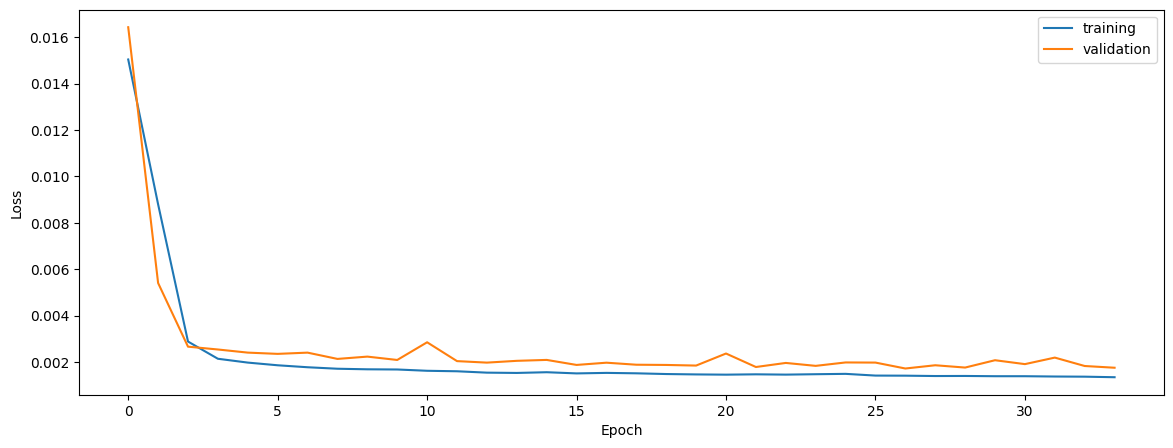

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.9442183227927227
0.9487213235165587
0.9431805839473666


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.9442183227927227
0.9487213235165587
0.9431805839473666


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.949881594994596
0.9526620006448075
0.9537683765191539


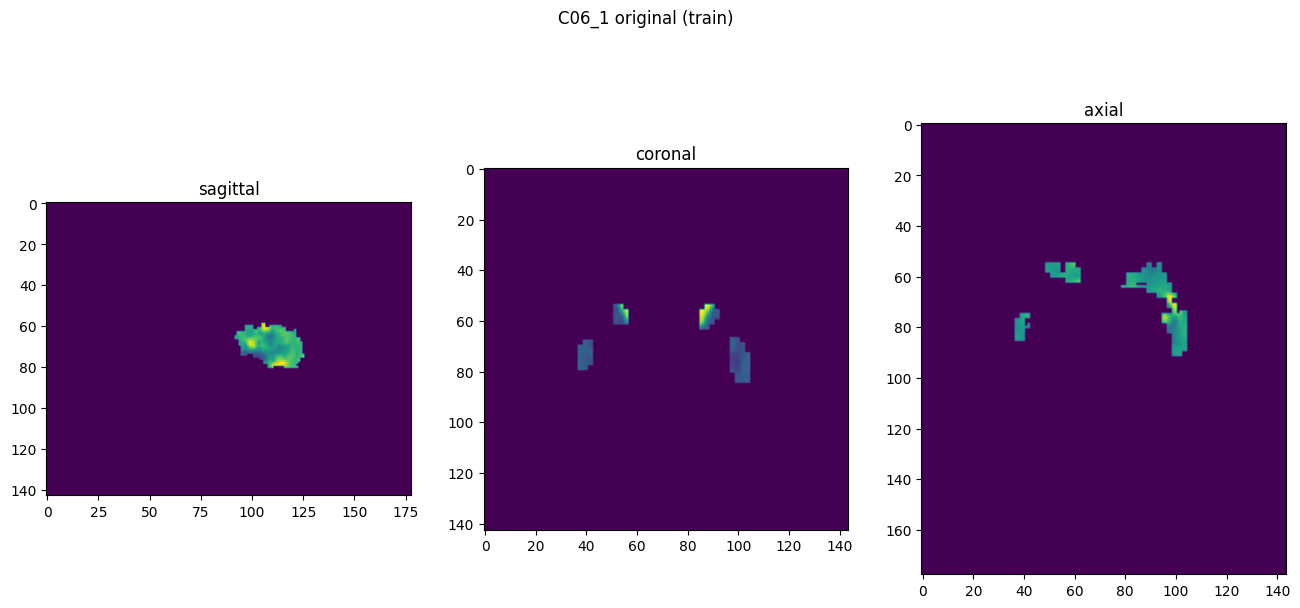

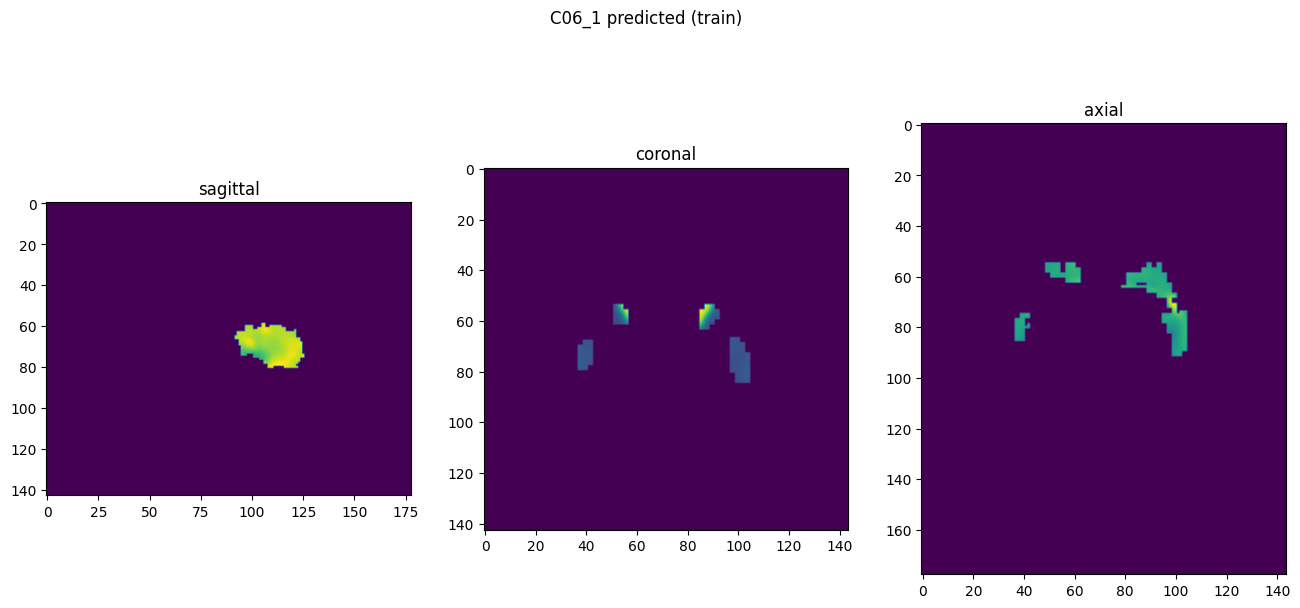

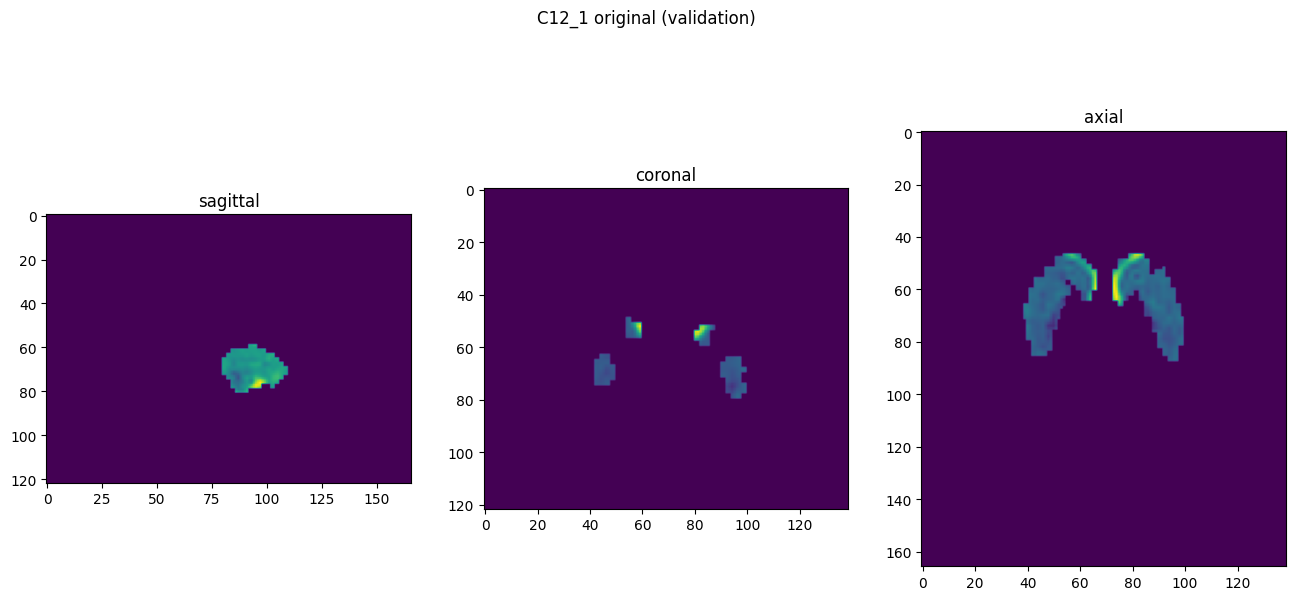

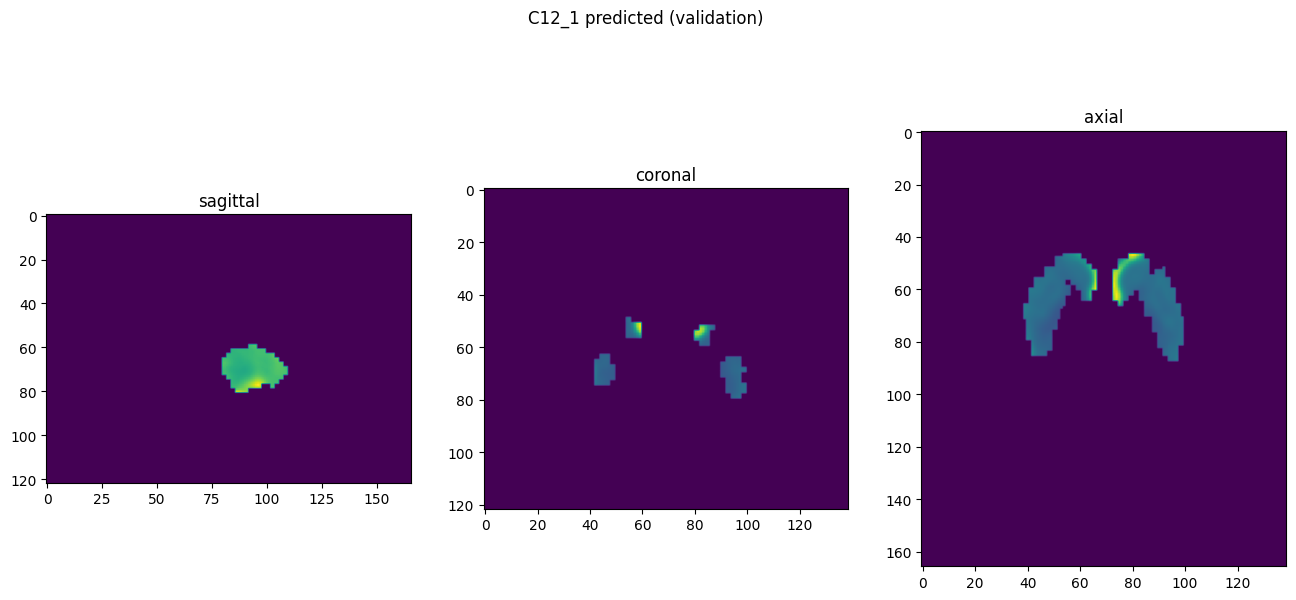

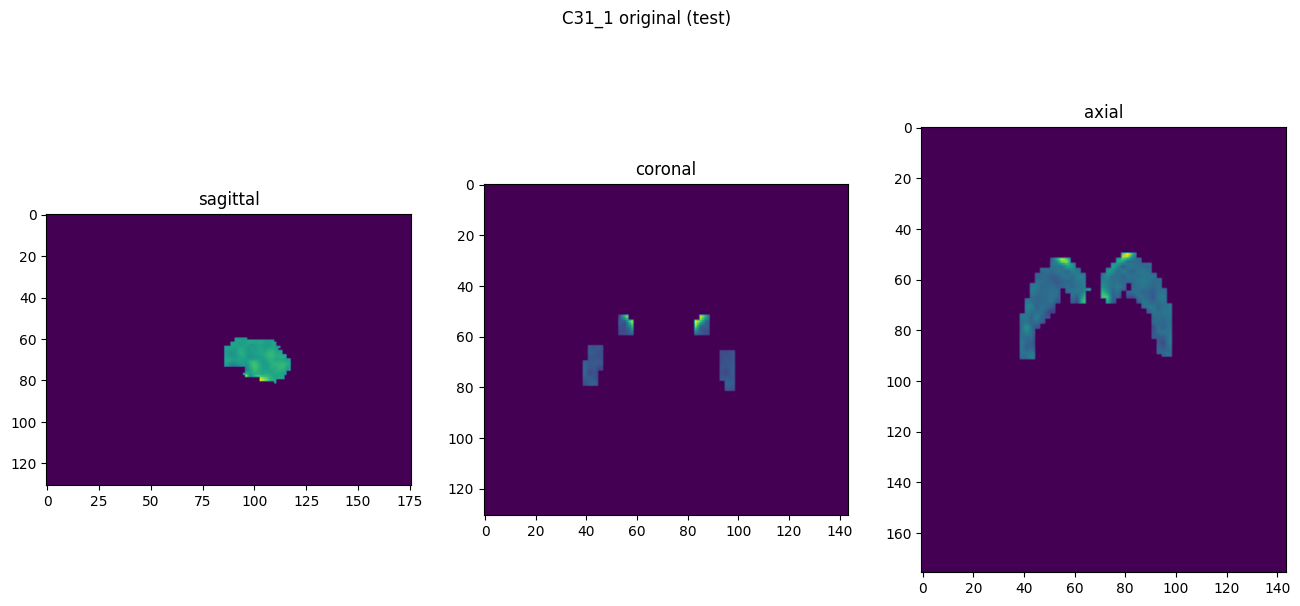

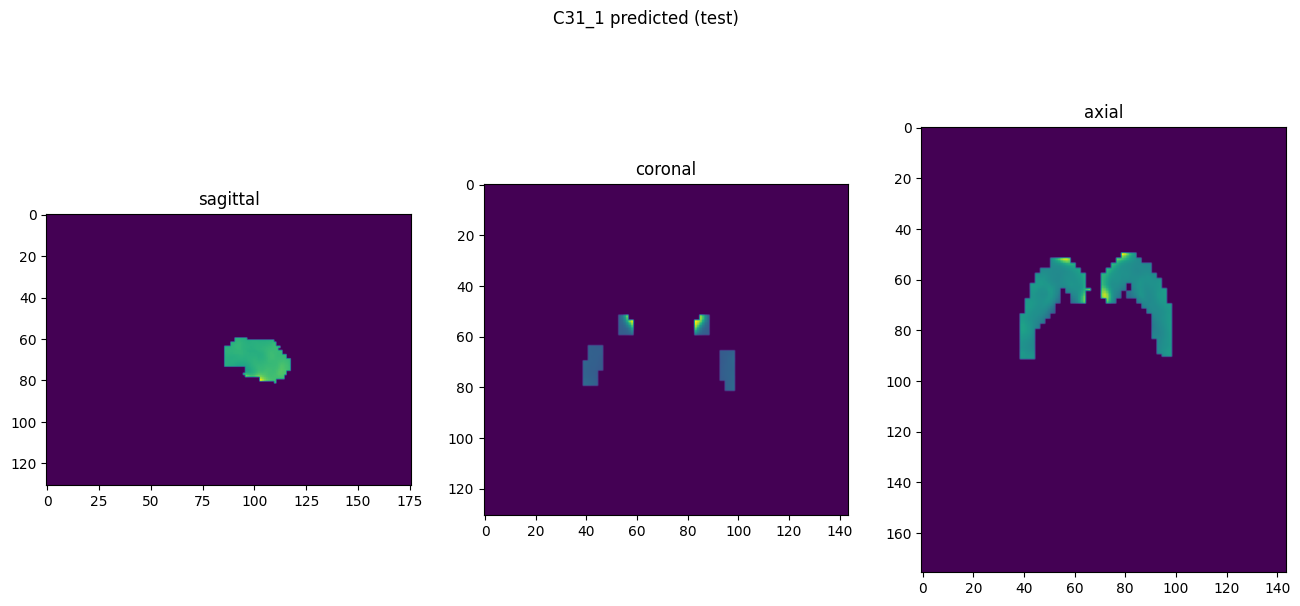

In [10]:
showResults(model, gen, threshold=None, background=False)